# Final Project Group 1

In [1]:
# New Package to install 

# First one is for the ALE Interface
! pip install ale-py


In [2]:
# Second one is for the ROMs (these are the games)
! pip install gymnasium[accept-rom-license]


zsh:1: no matches found: gymnasium[accept-rom-license]


In [3]:
# Necessary Libraries

import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os

# Set the environment variable to turn off TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2023-11-16 20:59:30.215732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# import ALE
from ale_py import ALEInterface
import ale_py.roms as roms
from ale_py.roms import Enduro

In [5]:
# available ROMS
print(dir(roms))

['Adventure', 'AirRaid', 'Alien', 'Amidar', 'Assault', 'Asterix', 'Asteroids', 'Atlantis', 'Atlantis2', 'Backgammon', 'BankHeist', 'BasicMath', 'BattleZone', 'BeamRider', 'Berzerk', 'Blackjack', 'Bowling', 'Boxing', 'Breakout', 'Carnival', 'Casino', 'Centipede', 'ChopperCommand', 'CrazyClimber', 'Crossbow', 'Darkchambers', 'Defender', 'DemonAttack', 'DonkeyKong', 'DoubleDunk', 'Earthworld', 'ElevatorAction', 'Enduro', 'Entombed', 'Et', 'FishingDerby', 'FlagCapture', 'Freeway', 'Frogger', 'Frostbite', 'Galaxian', 'Gopher', 'Gravitar', 'Hangman', 'HauntedHouse', 'Hero', 'HumanCannonball', 'IceHockey', 'Jamesbond', 'JourneyEscape', 'Kaboom', 'Kangaroo', 'KeystoneKapers', 'KingKong', 'Klax', 'Koolaid', 'Krull', 'KungFuMaster', 'LaserGates', 'LostLuggage', 'MarioBros', 'MiniatureGolf', 'MontezumaRevenge', 'MrDo', 'MsPacman', 'NameThisGame', 'Othello', 'Pacman', 'Phoenix', 'Pitfall', 'Pitfall2', 'Pong', 'Pooyan', 'PrivateEye', 'Qbert', 'Riverraid', 'RoadRunner', 'Robotank', 'Seaquest', 'SirL

In [6]:
# Define the A2C (Actor-Critic) architecture
class ActorCritic(tf.keras.Model):
    def __init__(self, num_actions):
        super(ActorCritic, self).__init__()
        self.conv1 = keras.layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu')
        self.conv2 = keras.layers.Conv2D(64, (5, 5), strides=(2, 2), activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(128, activation='relu')
        self.policy_logits = keras.layers.Dense(num_actions, activation='softmax')
        self.dense2 = keras.layers.Dense(128, activation='relu')
        self.values = keras.layers.Dense(1)
        # self.softmax = keras.layers.Softmax()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        logits = self.policy_logits(x)
        # logits_probs = self.softmax(logits)
        v = self.dense2(x)
        values = self.values(v)
        return logits, values
        # return logits_probs, values

In [7]:

# Define the actor-critic agent
class A2CAgent:
    def __init__(self, model, num_actions):
        self.model = model
        self.num_actions = num_actions

    def get_action(self, state):
        logits, _ = self.model(state)
        # normalize the logits probabilities because they do not sum to 1 in the np.random.choice() function the way they exist from the model
        p = np.asarray(logits[0]).astype('float64')
        p = p / np.sum(p)
        action = np.random.choice(self.num_actions, p=p)
        # action = np.random.choice(self.num_actions, p=np.exp(logits[0]))
        return action

In [8]:

# Create the Enduro environment
env = gym.make("ALE/Enduro-ram-v5", render_mode="rgb_array")

num_actions = env.action_space.n

# Initialize the actor-critic model
model = ActorCritic(num_actions)
optimizer = keras.optimizers.Adam(learning_rate=0.01)

# Create the actor-critic agent
agent = A2CAgent(model, num_actions)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [9]:
# Training loop
num_episodes = 1000
reward_history = []
mse_history = []
rmse_history = []  # Add RMSE history
weights_history = []
win_rate_history = []

for episode in range(num_episodes):
    state, _ = env.reset()
    terminated = True
    episode_reward = 10

    while not terminated:
        state = np.expand_dims(state, axis=0).astype(np.float32)
        action = agent.get_action(state)

        next_state, reward, terminated, _, _ = env.step(action)
        episode_reward += reward

        _, next_value = model(np.expand_dims(next_state, axis=0).astype(np.float32))
        _, value = model(state)

        advantage = reward + 0.99 * next_value - value
        td_error = tf.stop_gradient(advantage)

        # Calculate Mean Squared Error (MSE) of the critic
        mse = tf.keras.losses.mean_squared_error(tf.stop_gradient(td_error), value)
        mse_history.append(float(mse.numpy()))

        # Calculate Root Mean Squared Error (RMSE)
        rmse = tf.sqrt(mse)
        rmse_history.append(float(rmse.numpy()))

        with tf.GradientTape() as tape:
            logits, _ = model(state)
            action_prob = tf.nn.softmax(logits)[0, action]
            actor_loss = -tf.math.log(action_prob) * td_error
            critic_loss = 0.5 * mse  # Use MSE as the critic loss
            total_loss = actor_loss + critic_loss

            grads = tape.gradient(total_loss, model.trainable_variables)

        optimizer.apply_gradients(
            (grad, var)
            for (grad, var) in zip(grads, model.trainable_variables)
            if grad is not None
        )

        state = next_state

    # Record metrics
    reward_history.append(episode_reward)

    # Record weights trajectory
    weights_trajectory = [tf.reduce_mean(weight).numpy() for weight in model.trainable_variables]
    weights_history.append(weights_trajectory)

    # Calculate win rate
    win_rate = sum(reward_history[-10:]) / 10.0  # Win rate over the last 10 episodes
    win_rate_history.append(win_rate)

    if episode % 10 == 0:
        mse_value = mse_history[-1] if mse_history else 0.0
        rmse_value = rmse_history[-1] if rmse_history else 0.0
        print(f"Episode: {episode}, Total Reward: {episode_reward}, MSE: {mse_value}, RMSE: {rmse_value}, Win Rate: {win_rate}")

env.close()


Episode: 0, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 1.0
Episode: 10, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 20, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 30, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 40, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 50, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 60, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 70, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 80, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 90, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 100, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 110, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 120, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 130, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rate: 10.0
Episode: 140, Total Reward: 10, MSE: 0.0, RMSE: 0.0, Win Rat

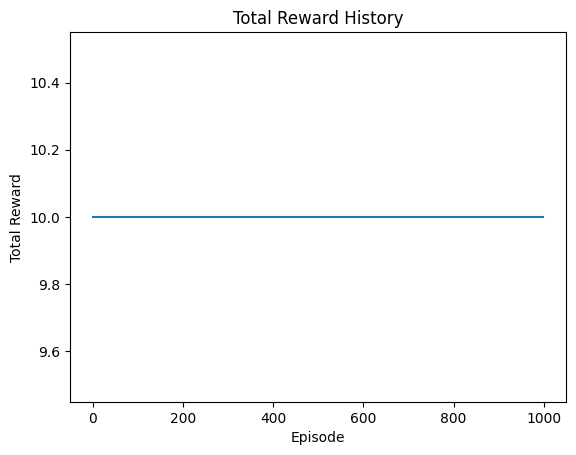

In [15]:
# Plot the Total Reward History

plt.plot(reward_history)
plt.title('Total Reward History')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

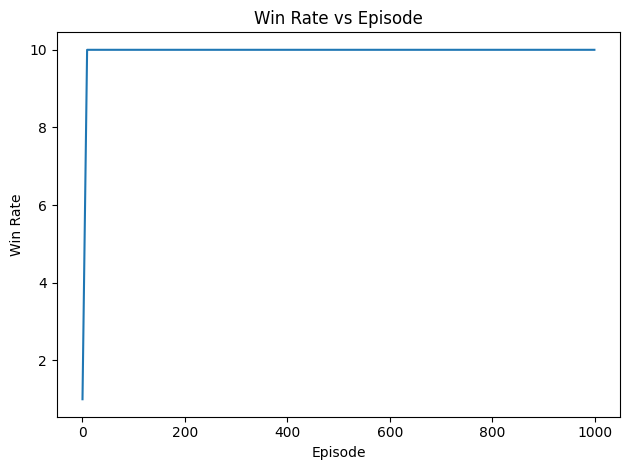

In [16]:
# Plot Win Rate vs Episode

plt.plot(np.arange(len(win_rate_history)), win_rate_history)
plt.title('Win Rate vs Episode')
plt.xlabel('Episode')
plt.ylabel('Win Rate')

plt.tight_layout()
plt.show()

In [18]:
print(reward_history)

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,

In [49]:
import numpy as np
import tensorflow as tf

# Hypothetical environment and agent
class Environment:
    def __init__(self):
        self.state_space = 4
        self.action_space = 2

    def reset(self):
        return np.random.rand(self.state_space)

    def step(self, action):
        next_state = np.random.rand(self.state_space)
        reward = np.random.randn()
        terminated = np.random.choice([True, False], p=[0.1, 0.9])
        return next_state, reward, terminated, None, None

class Agent:
    def __init__(self, model):
        self.model = model

    def get_action(self, state):
        # A simple policy, choose action based on the sign of the first state value
        return 0 if state[0, 0] > 0 else 1

# Hypothetical model
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense2 = tf.keras.layers.Dense(1)

    def call(self, state):
        x = self.dense1(state)
        value = self.dense2(x)
        return x, value

# Instantiate environment, agent, and model
env = Environment()
model = Model()
agent = Agent(model)

# Training loop
num_episodes = 1000
reward_history = []
mse_history = []
rmse_history = []
weights_history = []
win_rate_history = []

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for episode in range(num_episodes):
    state = env.reset()
    terminated = False
    episode_reward = 10

    while not terminated:
        state = np.expand_dims(state, axis=0).astype(np.float32)
        action = agent.get_action(state)

        next_state, reward, terminated, _, _ = env.step(action)
        episode_reward += reward

        _, next_value = model(np.expand_dims(next_state, axis=0).astype(np.float32))
        _, value = model(state)

        advantage = reward + 0.99 * next_value - value
        td_error = tf.stop_gradient(advantage)

        # Calculate Mean Squared Error (MSE) of the critic
        mse = tf.keras.losses.mean_squared_error(tf.stop_gradient(td_error), value)
        mse_history.append(float(mse.numpy()))

        # Calculate Root Mean Squared Error (RMSE)
        rmse = tf.sqrt(mse)
        rmse_history.append(float(rmse.numpy()))

        with tf.GradientTape() as tape:
            logits, _ = model(state)
            action_prob = tf.nn.softmax(logits)[0, action]
            actor_loss = -tf.math.log(action_prob) * td_error
            critic_loss = 0.5 * mse  # Use MSE as the critic loss
            total_loss = actor_loss + critic_loss

            grads = tape.gradient(total_loss, model.trainable_variables)

        optimizer.apply_gradients(
            (grad, var)
            for (grad, var) in zip(grads, model.trainable_variables)
            if grad is not None
        )

        state = next_state

    # Record metrics
    reward_history.append(episode_reward)

    # Record weights trajectory
    weights_trajectory = [tf.reduce_mean(weight).numpy() for weight in model.trainable_variables]
    weights_history.append(weights_trajectory)

    # Calculate win rate
    win_rate = sum(reward_history[-10:]) / 10.0  # Win rate over the last 10 episodes
    win_rate_history.append(win_rate)

    if episode % 10 == 0:
        mse_value = mse_history[-1] if mse_history else 0.0
        rmse_value = rmse_history[-1] if rmse_history else 0.0
        print(f"Episode: {episode}, Total Reward: {episode_reward}, MSE: {mse_value}, RMSE: {rmse_value}, Win Rate: {win_rate}")

# End of the training loop


Episode: 0, Total Reward: 9.617633491189336, MSE: 1.818242073059082, RMSE: 1.3484220504760742, Win Rate: 0.9617633491189336
Episode: 10, Total Reward: 9.3470225494731, MSE: 1.1595911979675293, RMSE: 1.0768431425094604, Win Rate: 9.237171485686478
Episode: 20, Total Reward: 1.219658052529492, MSE: 2.6734819412231445, RMSE: 1.6350785493850708, Win Rate: 8.951973531951925
Episode: 30, Total Reward: 9.199138123160939, MSE: 2.0347506999969482, RMSE: 1.4264469146728516, Win Rate: 10.317057077391688
Episode: 40, Total Reward: 11.71109166744592, MSE: 0.37363317608833313, RMSE: 0.611255407333374, Win Rate: 10.78810063145624
Episode: 50, Total Reward: 8.305405186290749, MSE: 0.7519752979278564, RMSE: 0.8671650886535645, Win Rate: 9.632870048858525
Episode: 60, Total Reward: 9.563919434356597, MSE: 0.4318810999393463, RMSE: 0.6571766138076782, Win Rate: 10.606426674027626
Episode: 70, Total Reward: 7.124303694053382, MSE: 0.015735287219285965, RMSE: 0.12544037401676178, Win Rate: 10.7293617217488

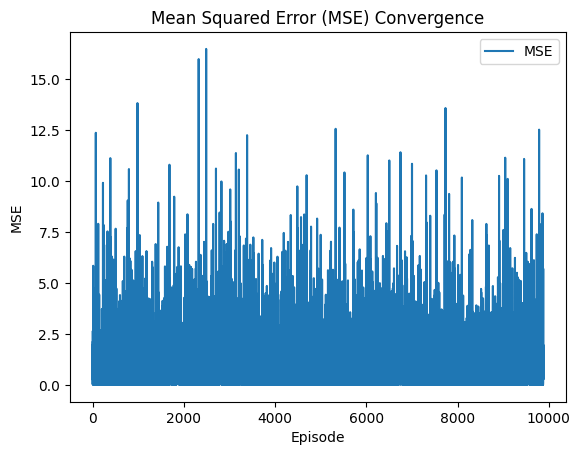

In [51]:
# Visualize the convergence process


# Plot Mean Squared Error (MSE)

plt.plot(mse_history, label='MSE')
plt.title('Mean Squared Error (MSE) Convergence')
plt.xlabel('Episode')
plt.ylabel('MSE')
plt.legend()



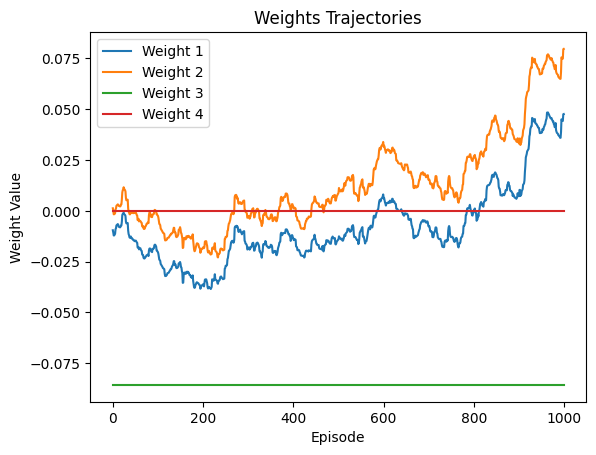

In [52]:
# Plot Weights Trajectories

weights_array = np.array(weights_history)
for i in range(weights_array.shape[1]):
    plt.plot(weights_array[:, i], label=f'Weight {i + 1}')
plt.title('Weights Trajectories')
plt.xlabel('Episode')
plt.ylabel('Weight Value')
plt.legend()



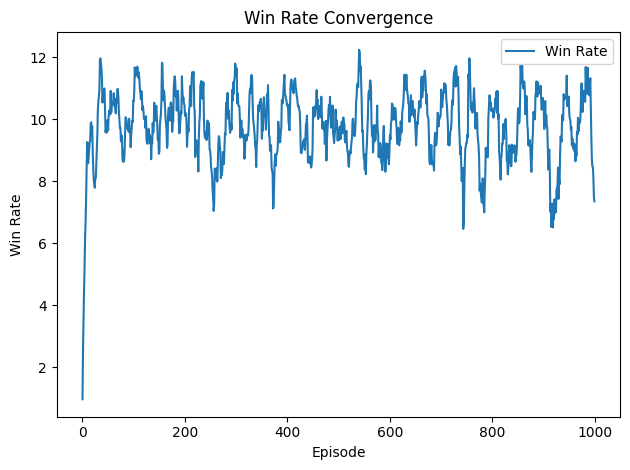

In [53]:
# Plot Win Rate

plt.plot(win_rate_history, label='Win Rate')
plt.title('Win Rate Convergence')
plt.xlabel('Episode')
plt.ylabel('Win Rate')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()